In [31]:
### Importing modules to be used

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# to get working day definition
import jpholiday

# to get time duration transformation from datetime to int
import datetime as dt

# to get a better view of deep differences on episode and show viewing percent
from matplotlib.colors import LogNorm

# to do the k clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Analysis

## Treatment of Data

1. Converting `view_start_time` and `view_end_time` to datetime format
2. Creating the `view_duration_time` the difference between `view_end_time` and `view_start_time`
3. Creating a boolean variable `is_weekend` to try to understand user loggin in behavior.
4. Transforming the `view_duration` from datetime type into seconds as integer
5. Encoding categorical data `episode_id, episode_type, show_id, user_id`

## Using clustering

1. Tried "traditional" analysis by checking some variables combination
2. Got some insights but clustering might be able to combine the similarities with more efficiency

In [2]:
# reading the csv data file
df = pd.read_csv('data/data_sample.csv')

# transforming the view times and calculating the duration
df['view_start_time'] = pd.to_datetime(df['view_start_time'])
df['view_end_time'] = pd.to_datetime(df['view_end_time'])
df['view_duration'] = df['view_end_time'] - df['view_start_time']


In [3]:
df['log_date_weekday'] = pd.to_datetime(df['log_date'])
df['log_date_weekday'].head()

0   2024-02-01
1   2024-02-02
2   2024-02-03
3   2024-02-03
4   2024-02-03
Name: log_date_weekday, dtype: datetime64[ns]

In [4]:
# adding a new variable is_workday

# Function to determine if a date is a working weekday
def is_working_day(date):
    return date.weekday() < 5 and not jpholiday.is_holiday(date)

df['is_working_day'] = df['log_date_weekday'].apply(is_working_day)

In [5]:
df.head()

,Unnamed: 0,episode_type,episode_id,show_id,user_id,log_date,view_start_time,view_end_time,view_percent,log_day_sequence,view_duration,log_date_weekday,is_working_day
0,0,a,ep00000002,s00000002,uu00000002,2024-02-01,2024-02-01 12:13:10,2024-02-01 12:13:24,0.000,1,0 days 00:00:14,2024-02-01,True
1,1,a,ep00000002,s00000002,uu00000016,2024-02-02,2024-02-02 23:32:55,2024-02-02 23:34:01,9.091,1,0 days 00:01:06,2024-02-02,True
2,2,a,ep00000002,s00000002,uu00000049,2024-02-03,2024-02-03 12:37:43,2024-02-03 12:38:46,9.091,1,0 days 00:01:03,2024-02-03,False
3,3,a,ep00000002,s00000002,uu00000050,2024-02-03,2024-02-03 20:59:06,2024-02-03 21:00:27,27.273,1,0 days 00:01:21,2024-02-03,False
4,4,a,ep00000002,s00000002,uu00000050,2024-02-03,2024-02-03 20:56:40,2024-02-03 20:57:09,9.091,1,0 days 00:00:29,2024-02-03,False


In [6]:
# Dropping Unnamed column
df = df.drop(columns=['Unnamed: 0'])

In [23]:
# Dropping non time formated data
#df = df.drop(columns=['view_start_time', 'view_end_time', 'view_duration'])
#df = df.drop(columns=['log_date_weekday'])
df = df.drop(columns=['log_date'])

In [7]:
#df_cleaned.to_csv('data/data_sample_improv.csv')

In [8]:
# Converting view_duration from datetime to int seconds
df['view_duration_seconds'] = df['view_duration'].dt.total_seconds().astype(int)

In [17]:
# encoding categorical data
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop(['log_date'])
df[categorical_cols] = df[categorical_cols].apply(lambda col: pd.factorize(col)[0])


,episode_type,episode_id,show_id,user_id,log_date,view_percent,log_day_sequence,log_date_weekday,is_working_day,view_duration_seconds
0,0,0,0,0,2024-02-01,0.000,1,2024-02-01,True,14
1,0,0,0,1,2024-02-02,9.091,1,2024-02-02,True,66
2,0,0,0,2,2024-02-03,9.091,1,2024-02-03,False,63
3,0,0,0,3,2024-02-03,27.273,1,2024-02-03,False,81
4,0,0,0,3,2024-02-03,9.091,1,2024-02-03,False,29


In [24]:
df.head()

,episode_type,episode_id,show_id,user_id,view_percent,log_day_sequence,is_working_day,view_duration_seconds
0,0,0,0,0,0.000,1,True,14
1,0,0,0,1,9.091,1,True,66
2,0,0,0,2,9.091,1,False,63
3,0,0,0,3,27.273,1,False,81
4,0,0,0,3,9.091,1,False,29


In [21]:
print(df.dtypes)

episode_type               int64
episode_id                 int64
show_id                    int64
user_id                    int64
log_date                  object
view_percent             float64
log_day_sequence           int64
is_working_day              bool
view_duration_seconds      int64
dtype: object


# Clustering

## Preparation

In [25]:
# Data preprocessing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_features, columns=df.columns)

# Find optimal number of clusters using elbow method
inertias = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertias.append(kmeans.inertia_)




Cluster Characteristics:
         episode_type   episode_id     show_id     user_id  view_percent  \
Cluster                                                                    
0            0.979675  3498.885671  117.439024  227.021341     62.692863   
1            1.207282  2758.894494   32.501954  263.779396     29.229322   
2            0.000303   351.212379   65.116505  347.315231     34.728897   
3            1.167420  4581.638481  178.991248  638.659797     36.228674   

         log_day_sequence  is_working_day  view_duration_seconds  
Cluster                                                           
0               18.019055        0.716209             165.580030  
1                5.256838        0.600000              80.779574  
2                2.369539        0.575698              93.608920  
3                5.919255        0.618295              91.976143  


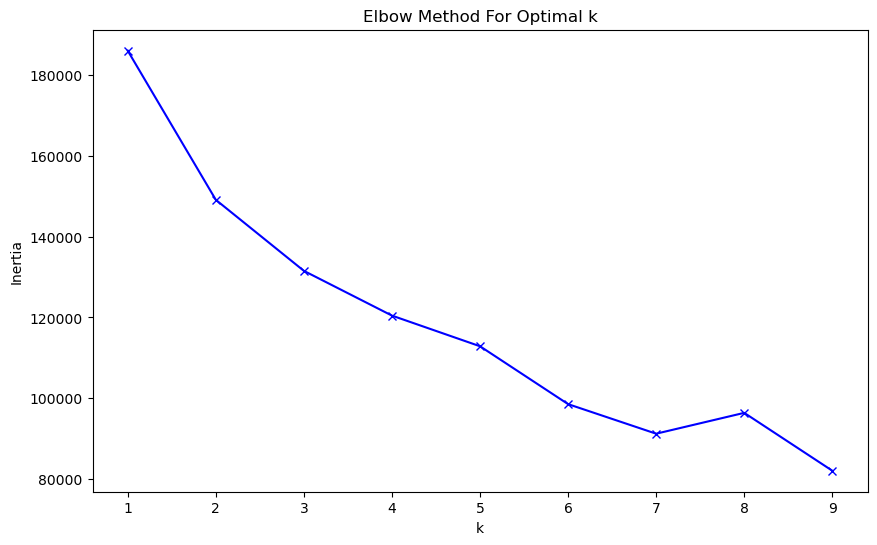

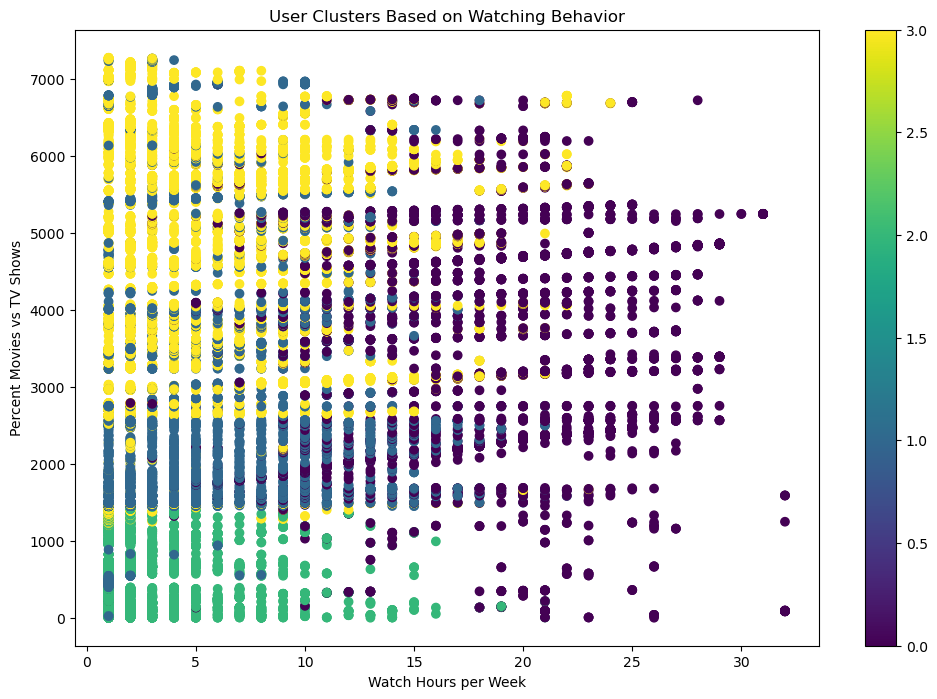

In [29]:
# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Perform clustering with optimal k=4
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_df)

# Analyze cluster characteristics
cluster_means = df.groupby('Cluster').mean()
print("\nCluster Characteristics:")
print(cluster_means)

# Visualize clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['log_day_sequence'], 
                     df['episode_id'],
                     c=df['Cluster'],
                     cmap='viridis')
plt.xlabel('Watch Hours per Week')
plt.ylabel('Percent Movies vs TV Shows')
plt.title('User Clusters Based on Watching Behavior')
plt.colorbar(scatter)
plt.show()


Cluster 0 characteristics:
High values in:
- log_day_sequence: 0.56
- episode_type: 0.49
- episode_id: 0.16
Low values in:
- show_id: -0.35
- user_id: -0.54
- Cluster: -1.07

Cluster 1 characteristics:
High values in:
- Cluster: 1.19
- user_id: 0.87
- episode_id: 0.86
Low values in:
- view_duration_seconds: -0.06
- view_percent: -0.07
- log_day_sequence: -0.13

Cluster 2 characteristics:
High values in:
- Cluster: 0.24
- view_duration_seconds: -0.06
- is_working_day: -0.10
Low values in:
- log_day_sequence: -0.65
- episode_id: -1.13
- episode_type: -1.29


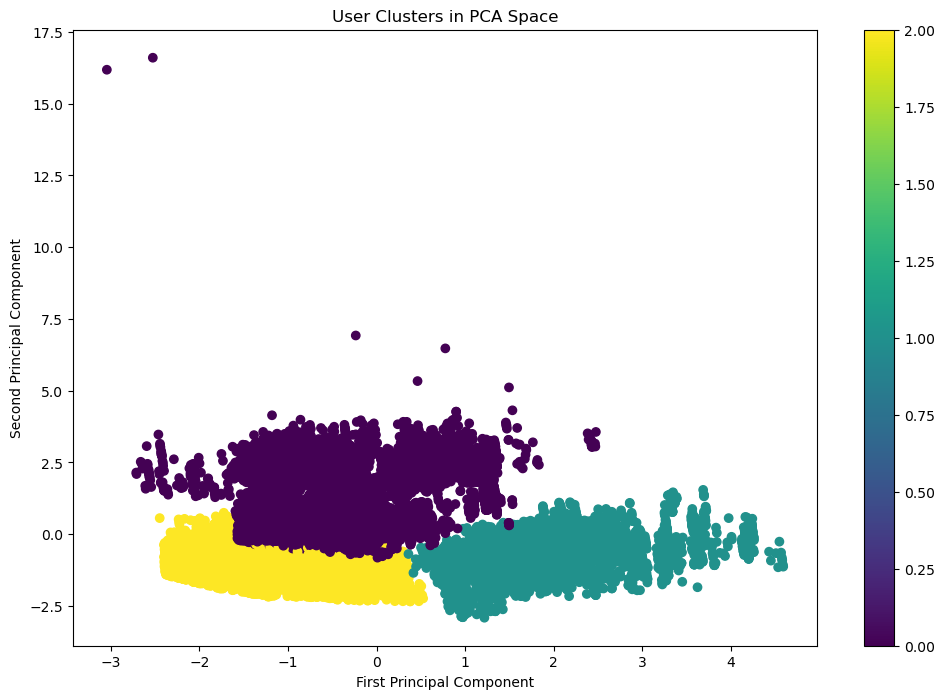

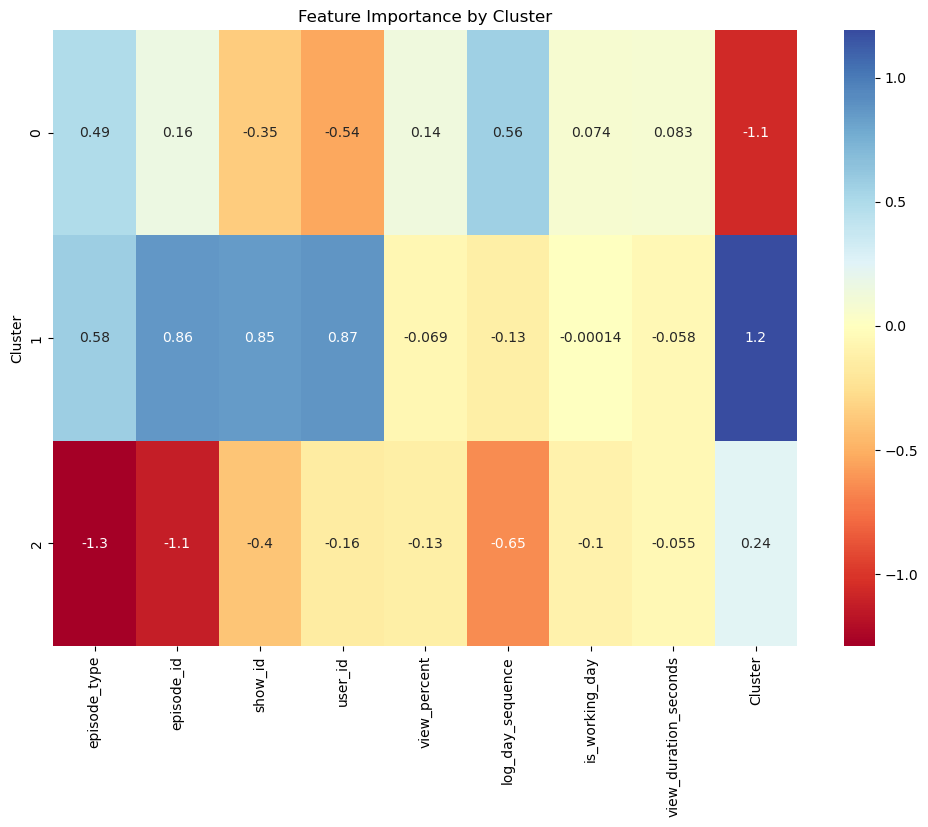

In [32]:

# 1. Feature preprocessing
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_features, columns=df.columns)

# 2. Apply PCA to reduce dimensionality and find most important patterns
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2'])

# 3. Find optimal k using silhouette analysis
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_k = K[np.argmax(silhouette_scores)]

# 4. Perform final clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# 5. Analyze feature importance for each cluster
cluster_means = df.groupby('Cluster').mean()
cluster_means_scaled = scaled_df.groupby(df['Cluster']).mean()

# 6. Visualize results using PCA components
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                     c=df['Cluster'], cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('User Clusters in PCA Space')
plt.colorbar(scatter)

# 7. Create feature importance heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means_scaled, annot=True, cmap='RdYlBu', center=0)
plt.title('Feature Importance by Cluster')

# 8. Function to characterize clusters
def characterize_clusters(cluster_means):
    for cluster in cluster_means.index:
        print(f"\nCluster {cluster} characteristics:")
        # Get top 3 distinguishing features
        features = cluster_means.loc[cluster].sort_values(ascending=False)
        print("High values in:")
        for feat, val in features.head(3).items():
            print(f"- {feat}: {val:.2f}")
        print("Low values in:")
        for feat, val in features.tail(3).items():
            print(f"- {feat}: {val:.2f}")

characterize_clusters(cluster_means_scaled)

plt.show()